# Variational autoencoder

The variational autoencoder should be able to identify abnormal heartbeat patterns.

In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
import gin
from streamer import VAEstreamer
import vae
from loguru import logger

import sys
import datasets, metrics
import mltrainer
from mltrainer import ReportTypes, Trainer, TrainerSettings


In [2]:
   
# use the binary data for training the Variational Autoencoder
trainfileVAE = Path('../data/heart_train.parq').resolve()
testfileVAE = Path('../data/heart_test.parq').resolve()
validationfileVAE = Path('../data/heart_test.parq').resolve()

# Remove outliers for training the VAE
traindatasetVAE = datasets.HeartDataset1D(trainfileVAE, target="target", outliersRemoval=True)
testdatasetVAE = datasets.HeartDataset1D(testfileVAE, target="target", outliersRemoval=True)
validationSetVAE = datasets.HeartDataset1D(validationfileVAE, target="target", outliersRemoval=False)

trainstreamerVAE = VAEstreamer(traindatasetVAE, batchsize=32).stream()
teststreamerVAE = VAEstreamer(testdatasetVAE, batchsize=32).stream()


In [3]:
gin.parse_config_file(Path('../src/config.gin').resolve())

X1, X2 = next(trainstreamerVAE)

encoder = vae.Encoder()
decoder = vae.Decoder()

latent = encoder(X1)
logger.info(f"the latent shape : {latent.shape}")

x = decoder(latent)
logger.info(f"the shape after: {x.shape}")

lossfn = vae.ReconstructionLoss()
loss = lossfn(x, X2)
logger.info(f"Untrained loss: {loss}")

logger.info(f"starting training for {200} epochs")
autoencoder = vae.AutoEncoder()

settings = TrainerSettings(
    epochs=200,
    metrics=[lossfn],
    logdir="logs",
    train_steps=200,
    valid_steps=200,
    reporttypes=[ReportTypes.TENSORBOARD],
    scheduler_kwargs={"factor": 0.1, "patience": 5},
)

trainer = Trainer(
    model=autoencoder,
    settings=settings,
    loss_fn=lossfn,
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamerVAE,
    validdataloader=teststreamerVAE,
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
)
trainer.loop()

2024-06-20 13:46:55.979 | INFO     | __main__:<module>:9 - the latent shape : torch.Size([32, 1])
2024-06-20 13:46:55.981 | INFO     | __main__:<module>:12 - the shape after: torch.Size([32, 192])
2024-06-20 13:46:55.983 | INFO     | __main__:<module>:16 - Untrained loss: 12.856250762939453
2024-06-20 13:46:55.984 | INFO     | __main__:<module>:18 - starting training for 200 epochs
2024-06-20 13:46:55.988 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/20240620-134655
2024-06-20 13:46:56.583 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 200/200 [00:00<00:00, 211.33it/s]
2024-06-20 13:46:57.793 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 3.0846 test 2.3659 metric ['2.3659']
100%|██████████| 200/200 [00:00<00:00, 261.77it/s]
2024-06-20 13:46:58.806 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 2.3131 test 2.2686 metric ['2.2686']
100%|██████████| 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import vae

autoencoder.eval()  # Set the model to evaluation mode
reconstruction_losses = []
targets = []

validation_loader = DataLoader(validationSetVAE, batch_size=1, shuffle=False)

with torch.no_grad():
    for X, y in tqdm(validation_loader, colour="#1e4706"):
        X = X.view(X.size(0), -1)  # Flatten the input if necessary
        yhat = autoencoder(X)
        # Compute reconstruction loss for each item in the batch
        loss = lossfn(X, yhat).cpu().numpy()  # Convert loss to numpy array
        
        # Append each individual loss and target to the lists
        reconstruction_losses.append(loss)
        targets.extend(y.cpu().numpy())
        


100%|██████████| 2911/2911 [00:01<00:00, 1526.76it/s]


Text(0, 0.5, 'Target')

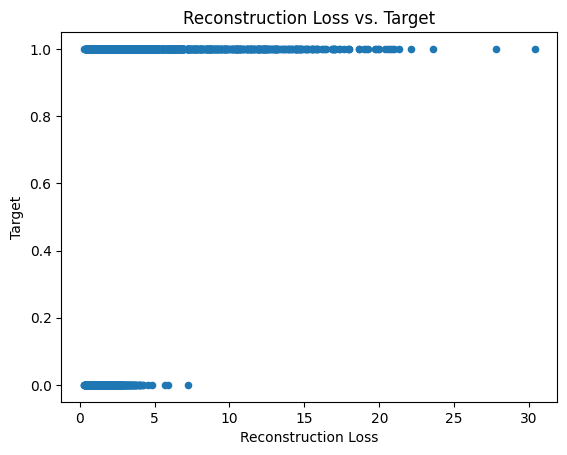

In [5]:
data = {
        'Reconstruction Loss': reconstruction_losses,
        'Target': targets
    }

# Create DataFrame for easy plotting
df = pd.DataFrame(data)
# print(df.head())

# Plot using Seaborn
df.plot.scatter(x='Reconstruction Loss', y='Target')
plt.title('Reconstruction Loss vs. Target')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Target')
